# Task 4  Prediction using historical data

In [6]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('History_data.csv')
for i in range(0,len(df)):
      if df['Adj Close'][i]== 0.0005:
        df['Adj Close'][i]=df['Adj Close'][i-1] +1
#print the head
print(df['Adj Close'][34])
df.head()

4322.970215


c:\users\bhuvan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Open,High,Low,Adj Close
0,7/1/1997,4263.109863,4301.770020,4247.660156,4300.859863
1,7/2/1997,4302.959961,4395.310059,4295.399902,4333.899902
2,7/3/1997,4335.790039,4393.290039,4299.970215,4323.459961
3,7/4/1997,4332.700195,4347.589844,4300.580078,4323.819824
4,7/7/1997,4326.810059,4391.009766,4289.490234,4291.450195


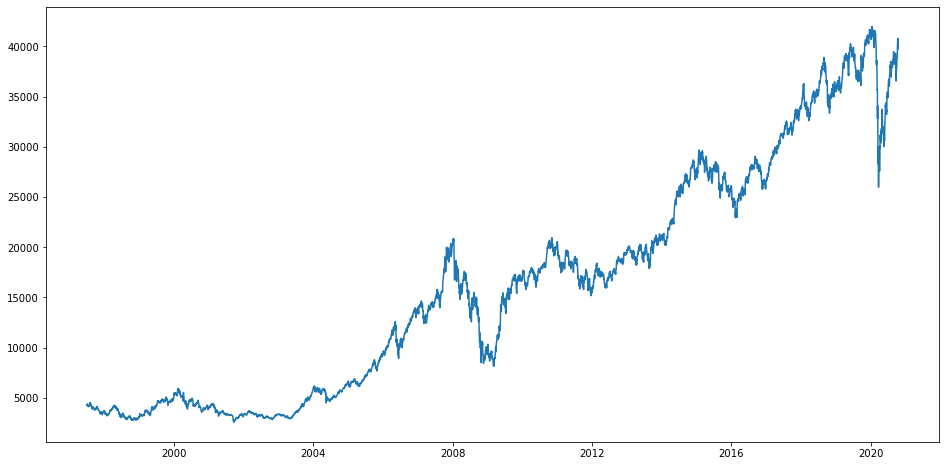

In [7]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'], label='Close Price history')

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj Close'][i] = data['Adj Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:int(0.8*len(data)),:]
valid = dataset[int(0.8*len(data)):,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1)

Epoch 1/1
4628/4628 [==============================] - 148s 32ms/step - loss: 4.1538e-04


In [15]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [16]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

677.4050193533831

c:\users\bhuvan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


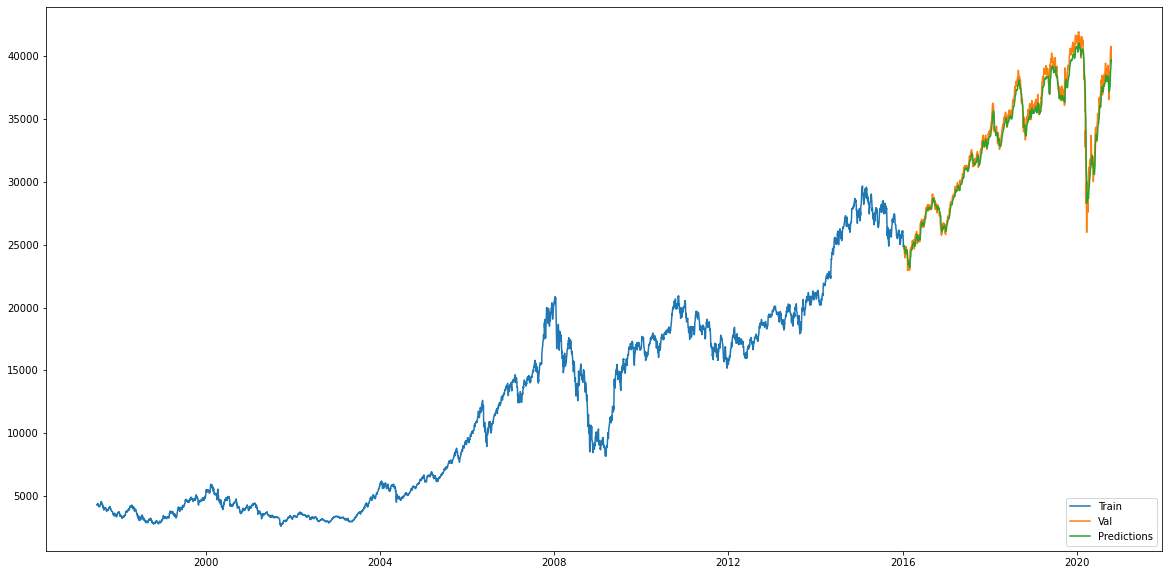

In [18]:
train = new_data[:int(0.8*len(data))]
valid = new_data[int(0.8*len(data)):]
valid['Predictions'] = closing_price
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close']])
plt.plot(valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')